In [1]:
#!pip install "tensorflow==2.6.0"
!pip install transformers datasets seqeval tensorboard --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.9 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=40128911309c652cec29448a5c5d830da3fd7b5002e4f17d36f9ab55440895ef
  Stor

In [2]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 3.9 MB/s eta 0:00:00


In [1]:
from huggingface_hub import notebook_login

notebook_login()

# Setup & Configuration
**In this step we will define global configurations and paramters, which are used across the whole end-to-end fine-tuning proccess, e.g. tokenizer and model we will use.**

In this example are we going to fine-tune the deepset/gbert-base a German BERT model.

In [2]:
model_id='deepset/gbert-base'

We can change the model_id to another BERT-like model for a different language, e.g. Italian or French to use this script to train a French or Italian Named Entity Recognition Model. But don't forget to also adjust the dataset in the next step.

# Dataset & Pre-processing

As Dataset we will use the GermanNER a german named entity recognition dataset from GermaNER: Free Open German Named Entity Recognition Tool paper. The dataset contains the four default coarse named entity classes LOCation, PERson, ORGanisation, and OTHer from the GermEval 2014 task. If you are fine-tuning in a different language then German you can search on the Hub for a dataset for your language or you can take a look at Datasets for Entity Recognition

In [3]:
dataset_id="germaner"
seed=33

In [4]:
# loading the germaner dataset
from datasets import load_dataset
dataset=load_dataset(dataset_id)

Generating train split:   0%|          | 0/26200 [00:00<?, ? examples/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 26200
    })
})

In [6]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 26200
})

In [7]:
dataset['train']['id'][0]

'0'

In [8]:
dataset['train']['ner_tags'][0]

[3, 8, 8, 8, 1, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [9]:
dataset['train']['tokens'][0]

['Schartau',
 'sagte',
 'dem',
 '"',
 'Tagesspiegel',
 '"',
 'vom',
 'Freitag',
 ',',
 'Fischer',
 'sei',
 '"',
 'in',
 'einer',
 'Weise',
 'aufgetreten',
 ',',
 'die',
 'alles',
 'andere',
 'als',
 'überzeugend',
 'war',
 '"',
 '.']

In [10]:
dataset['train'].num_rows

26200

In [11]:
dataset['train'].features['tokens'].feature

Value(dtype='string', id=None)

In [12]:
dataset['train'].features['id']

Value(dtype='string', id=None)

In [13]:
dataset['train'].features['tokens']

Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)

In [14]:
dataset['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags'],
    num_rows: 26200
})

In [15]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O'], id=None), length=-1, id=None)}

In [16]:
dataset['train'].features['ner_tags']

Sequence(feature=ClassLabel(names=['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O'], id=None), length=-1, id=None)

In [17]:
dataset['train'].features['ner_tags'].feature
# Values in a tuple is get accessed by .


ClassLabel(names=['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O'], id=None)

In [18]:
ner_labels=dataset['train'].features['ner_tags'].feature.names

In [19]:
dataset['train']['ner_tags'][0]

[3, 8, 8, 8, 1, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

In [20]:
dataset['train'][f'ner_tags'][3]

[1, 5, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]

# Pre-processing & Tokenization
**To train our model we need to convert our "Natural Language" to token IDs. This is done by a 🤗 Transformers Tokenizer which will tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary)**

In [21]:
from transformers import AutoTokenizer
tokenizer=AutoTokenizer.from_pretrained(model_id)

**Compared to a text-classification dataset of question-answering dataset is "text" of the germaner already split into a list of words (tokens). So cannot use tokenzier(text) we need to pass is_split_into_words=True to the tokenizer method. Additionally we add the truncation=True to truncate texts that are bigger than the maximum size allowed by the model.**

In [22]:
tokenized_inputs=tokenizer(dataset['train']['tokens'], truncation=True, is_split_into_words=True) # is_Split_into_words-> means input text is already tokenized into words.

In [23]:
def tokenize_align_and_labels(examples):
  tokenized_inputs=tokenizer(examples['tokens'], truncation=True, is_split_into_words=True)
  labels=[]

  for i, label in enumerate(examples[f'ner_tags']):
    previous_word_idx=None
    label_ids=[]
    word_ids=[]
    word_ids=tokenized_inputs.word_ids(batch_index=i)
    print(word_ids)
    print('\n')
    for word_idx in word_ids:
      if word_idx is None:
        label_ids.append(-100)
      elif word_idx!=previous_word_idx:
        label_ids.append(label[word_idx])
      else:
        label_ids.append(label[word_idx])
      previous_word_idx=word_idx

    labels.append(label_ids)
  tokenized_inputs['labels']=labels
  return tokenized_inputs

Process our dataset using .map method with batched=True.

In [24]:
tokenized_datasets=dataset.map(tokenize_align_and_labels, batched=True)

Map:   0%|          | 0/26200 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.


[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 17, 18, 18, 18, 19, 20, None]


[None, 0, 1, 2, 3, 4, 5, 6, 6, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 17, 18, 18, 19, 20, 21, 21, 21, 22, 23, 23, 24, 25, 25, 26, 27, 27, 28, 28, 28, 29, None]


[None, 0, 1, 2, 3, 4, 4, 5, 5, 6, 7, 7, 7, 7, 8, 9, 9, 9, 10, 11, 11, 11, 12, 13, 13, 13, 14, 15, 16, 16, 17, 18, 19, 20, None]


[None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 9, 10, 11, 12, 13, 13, 13, 14, 15, 16, 16, 17, 18, 19, 19, 20, 21, 22, 23, 24, 25, 26, 27, 27, 28, 29, 30, 30, 30, 31, 32, 33, 33, 34, 35, None]


[None, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 11, 12, None]


[None, 0, 1, 1, 1, 1, 2, 3, 3, 4, 4, 4, 5, 6, 7, 8, 9, 10, 11, 11, 11, 12, 13, 14, 14, 14, 15, 16, 16, 17, 18, 18, 19, 19, 20, None]


[None, 0, 1, 1, 2, 3, 4, 4, 4, 4, 4, 4, 5, 6, None]


[None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 14, 14, 14, 15, 16, 17, 18, 18, 19, 20, 2

In [25]:
tokenized_datasets['train']

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 26200
})

Since we later only need the tokenized + labels columns for the model to train, we are just filtering out which columns have been added by processing the dataset. The tokenizer_columns are the dataset column(s) to load in the tf.data.Dataset

In [26]:
dataset['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O'], id=None), length=-1, id=None)}

In [27]:
tokenized_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['B-LOC', 'B-ORG', 'B-OTH', 'B-PER', 'I-LOC', 'I-ORG', 'I-OTH', 'I-PER', 'O'], id=None), length=-1, id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'token_type_ids': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None)}

In [31]:
pre_tokenizer_columns=set(dataset['train'].features)
print(pre_tokenizer_columns)
tokenizer_columns=list(set(tokenized_datasets['train'].features)-set(dataset['train'].features))
print(tokenizer_columns)

{'ner_tags', 'id', 'tokens'}
['token_type_ids', 'attention_mask', 'input_ids', 'labels']


Since our dataset only includes one split (train) we need to train_test_split ourself to have an evaluation/test dataset for evaluating the result during and after training.

In [32]:
test_size=0.15
process_datasets=tokenized_datasets['train'].shuffle(seed=seed).train_test_split(test_size=test_size)
print(process_datasets)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 22270
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 3930
    })
})


# fine tune the model

**Now our dataset is preprocessed, so we will download the pretrained model and fine tune it. for this we will convert our dataset into tf.data.Dataset format.for this we will use to_tf_dataset method and a data Collator for token Classification(Data collators are objects that will form a batch by using a list of datasets element as input)**

# **Hyperparameters**

In [38]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label={str(i):label for i, label in enumerate(ner_labels)}
label2id={v:k for k,v in id2label.items()}

num_train_epochs=5
train_batch_size=16
eval_batch_size=32
learning_rate=2e-6
weight_decay_rate=0.01
num_warmup_steps=0
output_dir= model_id.split('/')[1]
hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
hub_model_id = f'{model_id.split("/")[1]}-{dataset_id}'
fp16=True
# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")


**Converting the dataset to a tf.data.Dataset**

In [34]:
from transformers import DataCollatorForTokenClassification
# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator=DataCollatorForTokenClassification(
    tokenizer=tokenizer, return_tensors='pt'
)

tf_train_dataset=process_datasets['train'].to_tf_dataset(
    columns=tokenizer_columns,
    shuffle=True,
    batch_size=train_batch_size,
    collate_fn=data_collator
)

tf_eval_dataset=process_datasets['test'].to_tf_dataset(
    columns=tokenizer_columns,
    shuffle=False,
    batch_size=eval_batch_size,
    collate_fn=data_collator
)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
len(tf_train_dataset), len(tf_eval_dataset)

(1392, 123)

In [ ]:
tf_train_dataset.element_spec['input_ids']

TensorSpec(shape=(None, None), dtype=tf.int64, name=None)

# **Download the pretrained transformer model and fine-tune it.**

In [35]:
from transformers import TFAutoModelForTokenClassification, create_optimizer

num_train_steps=len(tf_train_dataset)*num_train_epochs

optimizer,lr_schedule=create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    weight_decay_rate=weight_decay_rate
)

model=TFAutoModelForTokenClassification.from_pretrained(
    model_id,
    id2label=id2label,
    label2id=label2id
)

model.compile(optimizer=optimizer)

All PyTorch model weights were used when initializing TFBertForTokenClassification.

Some weights or buffers of the TF 2.0 model TFBertForTokenClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#**Callbacks**

*Here we will use Hugging face hub model for versioning and monitoring.
Therefore we want to push our model weights during training and after training to hub to version it.

Additionally we want to track the performance during training therefore we will push the tensorboard along with the weights to the Hub to use the training metrics feature to monitor our training in real time.
 *

In [36]:
import os

from transformers.keras_callbacks import PushToHubCallback  #import a callback from the Huggingface Transformers library then enables pushing a trained model to huggingface model HUb
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback
# Imports the TensorboardCallback class from TensorFlow's Keras library, which is used for logging training and validation information for visualization in TensorBoard.

callbacks=[] # To store different callback instances

callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))

"""The code appends an instance of the TensorboardCallback to the callbacks list.
TensorboardCallback is being initialized with the log_dir parameter, which specifies the directory where the logs for TensorBoard will be stored.
The value of os.path.join(output_dir, "logs") is used as the log directory. output_dir is expected to be a previously defined variable that represents the directory
 where the model and related artifacts are stored."""

if hub_token:
  callbacks.append(PushToHubCallback(
      tokenizer=tokenizer,
      output_dir=output_dir,
      hub_model_id=hub_model_id,
      hub_token=hub_token
  ))

  """The code checks if a variable hub_token has a truthy value (meaning it's not empty or False).
If the condition is met (i.e., hub_token has a value), an instance of the PushToHubCallback is appended to the callbacks list.
PushToHubCallback is initialized with several parameters:
output_dir: The directory where the trained model and related artifacts are stored.
tokenizer: A Hugging Face tokenizer used for encoding and decoding text data for the model.
hub_model_id: The ID or name of the model on the Hugging Face Model Hub.
hub_token: An authentication token required to upload the model to the Hugging Face Model Hub"""


Cloning https://huggingface.co/pankaj10034/gbert-base-germaner into local empty directory.


Download file tf_model.h5:   0%|          | 16.4k/417M [00:00<?, ?B/s]

Download file logs/validation/events.out.tfevents.1689048798.784b5a50beba.386.1.v2: 100%|##########| 544/544 […

Clean file logs/validation/events.out.tfevents.1689048798.784b5a50beba.386.1.v2: 100%|##########| 544/544 [00:…

Download file logs/validation/events.out.tfevents.1689050071.784b5a50beba.10221.1.v2: 100%|##########| 232/232…

Clean file logs/validation/events.out.tfevents.1689050071.784b5a50beba.10221.1.v2: 100%|##########| 232/232 [0…

Download file logs/train/events.out.tfevents.1689048549.784b5a50beba.386.0.v2:   0%|          | 16.4k/3.43M [0…

Download file logs/train/events.out.tfevents.1689049476.784b5a50beba.386.2.v2:   0%|          | 7.40k/3.43M [0…

Download file logs/train/events.out.tfevents.1689049807.784b5a50beba.10221.0.v2:   0%|          | 16.5k/3.43M …

Clean file logs/train/events.out.tfevents.1689048549.784b5a50beba.386.0.v2:   0%|          | 1.00k/3.43M [00:0…

Clean file logs/train/events.out.tfevents.1689049807.784b5a50beba.10221.0.v2:   0%|          | 1.00k/3.43M [00…

Clean file logs/train/events.out.tfevents.1689049476.784b5a50beba.386.2.v2:   0%|          | 1.00k/3.43M [00:0…

Clean file tf_model.h5:   0%|          | 1.00k/417M [00:00<?, ?B/s]

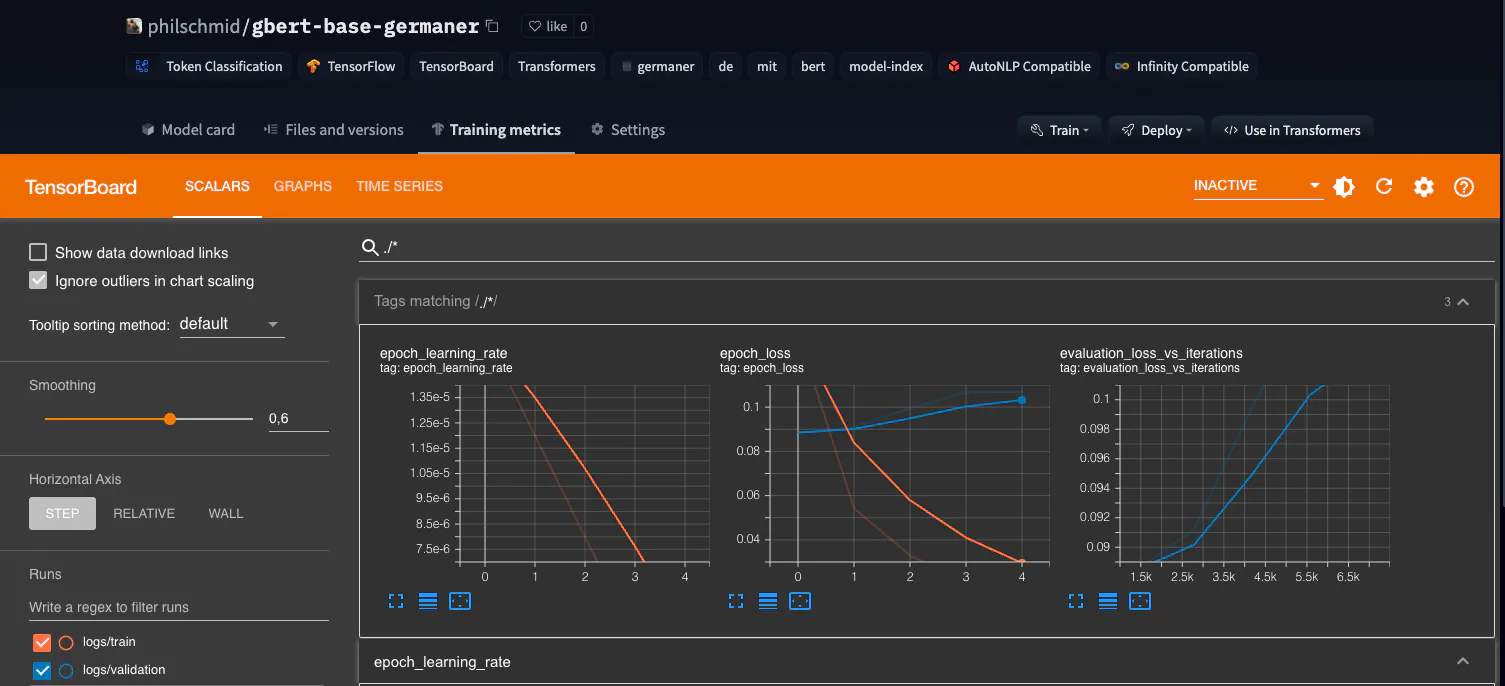

# **Training**
Start training with calling model.fit

In [ ]:
Hisory=model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs
)

Epoch 1/5
1392/1392 [==============================] - 299s 193ms/step - loss: 0.1379 - val_loss: 0.0909
Epoch 2/5
1392/1392 [==============================] - 266s 191ms/step - loss: 0.0558 - val_loss: 0.0848
Epoch 3/5
1392/1392 [==============================] - 266s 191ms/step - loss: 0.0328 - val_loss: 0.0899
Epoch 4/5
1392/1392 [==============================] - 283s 203ms/step - loss: 0.0201 - val_loss: 0.1012
Epoch 5/5
1392/1392 [==============================] - 324s 233ms/step - loss: 0.0137 - val_loss: 0.1076


NameError: ignored

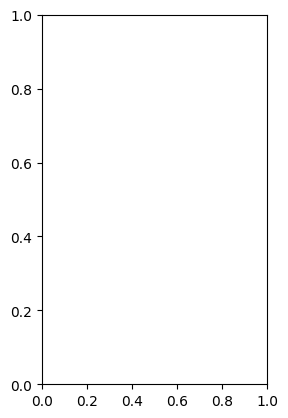

In [40]:
import matplotlib.pyplot as plt
plt.subplot(1,2,1)
plt.plot(Hisory.history['loss'])
plt.xlabel('num_epochs')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.plot(Hisory.history['val_loss'])
plt.xlabel('num_epochs')
plt.ylabel('Val_loss')

**Evaluation
The traditional framework used to evaluate token classification prediction is seqeval. This metric does not behave like the standard accuracy: it will actually take the lists of labels as strings, not integers, so we will need to fully decode the predictions and labels before passing them to the metric**

In [41]:
from datasets import load_metric
import numpy as np

metric=load_metric('seqeval')

def evaluate(model, dataset, ner_labels):
  all_predictions=[]
  all_labels=[]

  for batch in dataset:
    logits=model.predict(batch)['logits']
    labels=batch['labels']

    predictions=np.argmax(logits, axis=-1)

    for prediction, label in zip(predictions, labels):
      for prediction_idx, label_idx in zip(prediction, label):
        if label_idx==-100:
          continue
        all_predictions.append(ner_labels[prediction_idx])
        all_labels.append(ner_labels[label_idx])
  return metric.compute(predictions=[all_predictions], references=[all_labels])
results = evaluate(model, tf_eval_dataset, ner_labels=list(model.config.id2label.values()))


<ipython-input-41-b33b9aaed078>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric=load_metric('seqeval')


1/1 [==============================] - 3s 3s/step


In [45]:
print(np.array(results))

{'LOC': {'precision': 0.8997875354107648, 'recall': 0.9150162045372704, 'f1': 0.9073379753615426, 'number': 2777}, 'ORG': {'precision': 0.7527533039647577, 'recall': 0.778030734206033, 'f1': 0.7651833193394907, 'number': 1757}, 'OTH': {'precision': 0.6669513236549958, 'recall': 0.741690408357075, 'f1': 0.7023381294964028, 'number': 1053}, 'PER': {'precision': 0.9215686274509803, 'recall': 0.9340380549682875, 'f1': 0.9277614447711046, 'number': 2365}, 'overall_precision': 0.8403996101364523, 'overall_recall': 0.8674547283702213, 'overall_f1': 0.8537128712871287, 'overall_accuracy': 0.9760785008915815}


# **Create Model Card with evaluation result**


To complete our Hugging Face Hub repository we will create a model card with the used hyperparameters and the evaluation results.

In [42]:
from transformers.modelcard import TrainingSummary


eval_results = {
    "precision":float(results["overall_precision"]),
    "recall":float(results["overall_recall"]),
    "f1":float(results["overall_f1"]),
    "accuracy":float(results["overall_accuracy"]),
}

training_summary = TrainingSummary(
    model_name = hub_model_id,
    language = "de",
    tags=[],
    finetuned_from=model_id,
    tasks="token-classification",
    dataset=dataset_id,
    dataset_tags=dataset_id,
    dataset_args="default",
    eval_results=eval_results,
    hyperparameters={
        "num_train_epochs": num_train_epochs,
        "train_batch_size": train_batch_size,
        "eval_batch_size": eval_batch_size,
        "learning_rate": learning_rate,
        "weight_decay_rate": weight_decay_rate,
        "num_warmup_steps": num_warmup_steps,
        "fp16": fp16
    }
)
model_card = training_summary.to_model_card()

model_card_path = os.path.join(output_dir, "README.md")

with open(model_card_path, "w") as f:
    f.write(model_card)


# **push model card to repository**

In [46]:
from huggingface_hub import HfApi

api = HfApi()

user = api.whoami(hub_token)

api.upload_file(
    token=hub_token,
    repo_id=f"{user['name']}/{hub_model_id}",
    path_or_fileobj=model_card_path,
    path_in_repo="README.md")

'https://huggingface.co/pankaj10034/gbert-base-germaner/blob/main/README.md'

# **Run Managed Training using Amazon Sagemaker**

If you want to run this examples on Amazon SageMaker to benefit from the Training Platform follow the cells below. I converted the Notebook into a python script train.py, which accepts same hyperparameter and can we run on SageMaker using the HuggingFace estimator



In [50]:
# !pip install sagemaker

In [ ]:
import sagemaker

sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

role = sagemaker.get_execution_role()
sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")


In [ ]:
from sagemaker.huggingface import HuggingFace

# gets role for executing training job
role = sagemaker.get_execution_role()
hyperparameters = {
	'model_id': 'deepset/gbert-base',
	'dataset_id': 'germaner',
	'num_train_epochs': 5,
	'train_batch_size': 16,
	'eval_batch_size': 32,
	'learning_rate': 2e-5,
	'weight_decay_rate': 0.01,
	'num_warmup_steps': 0,
	'hub_token': HfFolder.get_token(),
	'hub_model_id': 'sagemaker-gbert-base-germaner',
	'fp16': True
}


# creates Hugging Face estimator
huggingface_estimator = HuggingFace(
	entry_point='train.py',
	source_dir='./scripts',
	instance_type='ml.p3.2xlarge',
	instance_count=1,
	role=role,
	transformers_version='4.12.3',
	tensorflow_version='2.5.1',
	py_version='py36',
	hyperparameters = hyperparameters
)

# starting the train job
huggingface_estimator.fit()


# Conclusion
**We managed to successfully fine-tune a German BERT model using Transformers and Keras, without any heavy lifting or complex and unnecessary boilerplate code. The new utilities like .to_tf_dataset are improving the developer experience of the Hugging Face ecosystem to become more Keras and TensorFlow friendly. Combining those new features with the Hugging Face Hub we get a fully-managed MLOps pipeline for model-versioning and experiment management using Keras callback API.**